In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from calendar import month_abbr
from datetime import datetime

from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import month_plot, plot_acf

from warnings import filterwarnings
filterwarnings('ignore')

É muito importante visualizar os dados de uma série temporal, isso ajuda nós a identificarmos vários padrões, identificar erros e eventos que ocorreram.
Podemos resumir em alguns bulletpoints:
- Identificar Padrões;
- Identificar Outliers;
- Identificar mudanças ao longo do tempo;
- Entender como as variações se relacionam.


Existem alguns padrões em séries temporais, são eles:
- Trend: Tendência "long term" aumentando ou diminuindo ao longo do tempo.
- Seasonal: "Seasonal Factors", a sazonalidade indica que a série é afetada por fatores sazonais como holidays ou fatores como mês, semana, hora, etc.
- Cyclic: "Rises and Fall", a série quando é cíclica apresenta flutuações dado a condições econômicas ou naturais, mas em geral são maiores que a sazonalidade e em dados anuais (cada linha é um ano) não existe sazonalidade MAS pode existir um período cíclico.


#### 0.0. Data Load 

In [2]:
# Ansett Dataset
df_ansett = pd.read_csv('../data/ansett.csv', index_col=[0])
df_ansett.columns = [k.lower() for k in df_ansett.columns]

df_ansett['week'] = df_ansett.week.apply(lambda x: x.replace(' W', '-'))

df_ansett['date_week'] = df_ansett['week'].apply(lambda x: datetime.fromisocalendar(int(x.split('-')[0]), int(x.split('-')[-1]), 1))


# PBS Dataset
dfbs = pd.read_csv('../data/PBS.csv', index_col=[0])

dfbs['Month'] = pd.to_datetime(dfbs['Month'], format='%Y %b')

dfbs['Month'].freq = 'MS'


# Aus Production
beer = pd.read_csv('../data/aus_production.csv', index_col=[0])
beer['Quarter'] = beer.Quarter.apply(lambda x: x.replace(' ', '-'))
beer['Quarter'] = pd.PeriodIndex(beer.Quarter, freq='Q').to_timestamp()


# Vic Elec Demand
vic_elec = pd.read_csv('../data/vic_elec.csv', index_col=[0])
vic_elec.columns = [k.lower() for k in vic_elec.columns]

vic_elec['time'] = pd.to_datetime(vic_elec['time'])


# Linx Dataset
df_l = pd.read_csv('../data/pelt.csv', index_col=[0])


# Us Change
df = pd.read_csv('../data/us_change.csv', index_col=[0])
df.Quarter = df.Quarter.apply(lambda x: x.replace(' ', '-'))
df.Quarter = pd.PeriodIndex(df.Quarter, freq='Q').to_timestamp()

#### 1.0. Time Plots

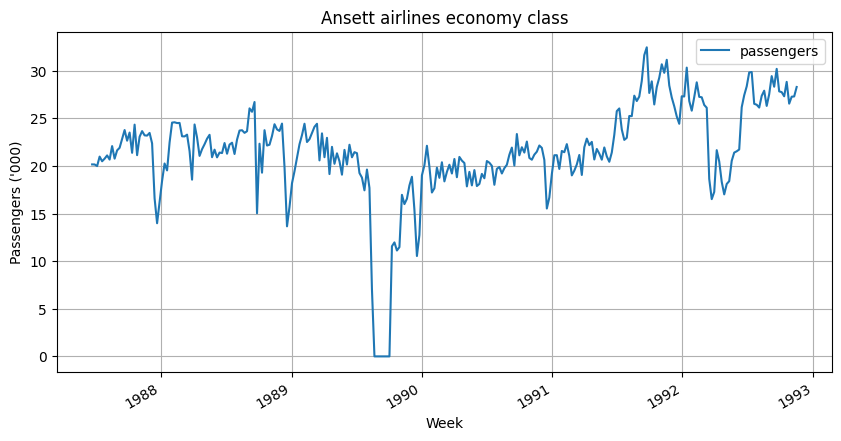

In [8]:
melsyd_economy = df_ansett[(df_ansett['airports'] == 'MEL-SYD') & (df_ansett['class'] == 'Economy')].reset_index(drop=True)

melsyd_economy['passengers'] = melsyd_economy['passengers'] / 1_000

melsyd_economy.plot(
    x='date_week',
    y='passengers',
    figsize=(10,5),
    xlabel='Week',
    ylabel="Passengers ('000)",
    title='Ansett airlines economy class',
    grid='on'
);

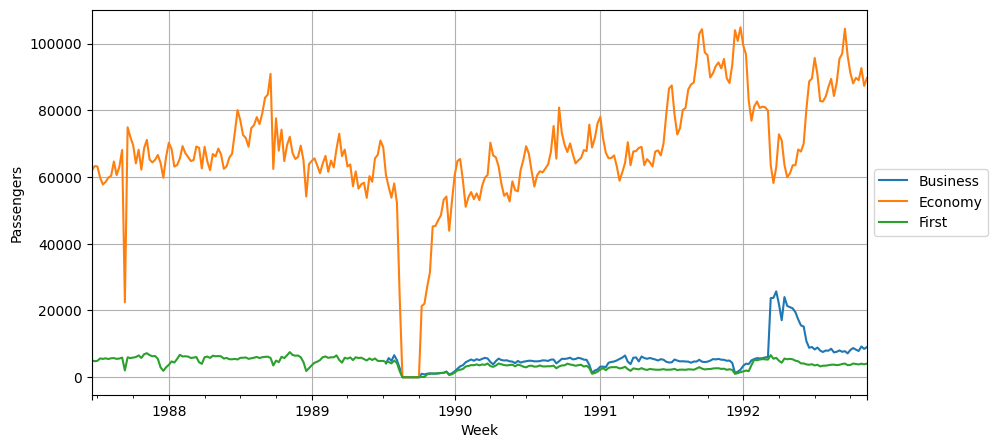

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))

for bclass in df_ansett["class"].unique():
    dfp = df_ansett[df_ansett["class"] == bclass]
    dfp = dfp[["passengers", "date_week"]].groupby("date_week").sum().reset_index()

    dfp.plot(
        x='date_week',
        y='passengers',
        ax=ax,
        label=bclass
    )

ax.set_xlabel("Week")
ax.set_ylabel("Passengers")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(2)

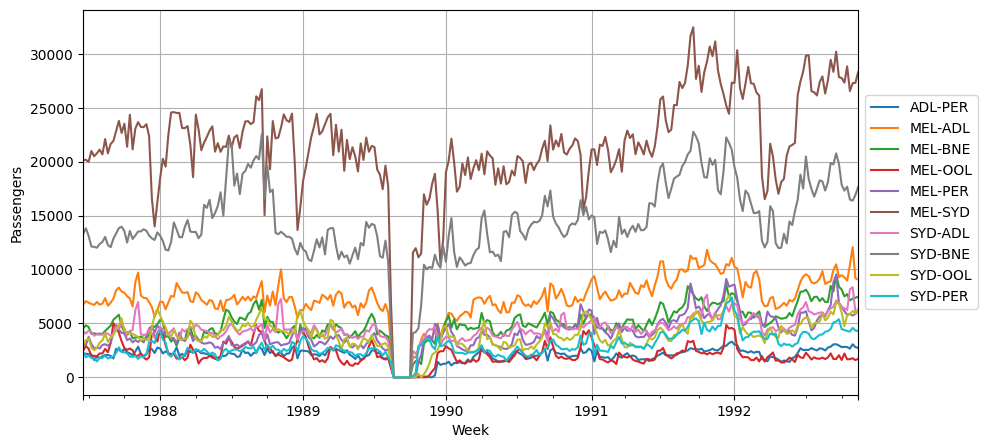

In [28]:
df_economy = df_ansett[df_ansett["class"] == "Economy"]

fig, ax = plt.subplots(figsize=(10, 5))

for airport in df_economy["airports"].unique():
    dfp = df_economy[df_economy["airports"] == airport]

    dfp.plot(
        x='date_week',
        y='passengers',
        ax=ax,
        label=airport
    )

ax.set_xlabel("Week")
ax.set_ylabel("Passengers")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(2)

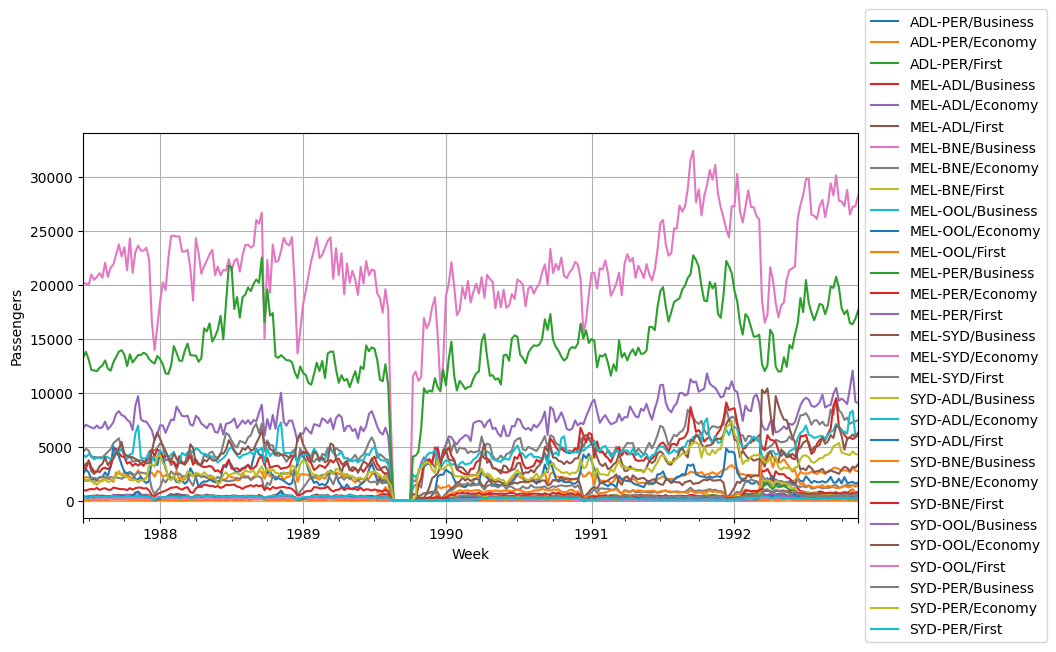

In [29]:
df_economy = df_ansett[df_ansett["class"] == "Economy"]

fig, ax = plt.subplots(figsize=(10, 5))

for airport in df_ansett["airports"].unique():
    dfp = df_ansett[df_ansett["airports"] == airport]

    for bclass in dfp["class"].unique():
        dfp2 = dfp[dfp["class"] == bclass]

        dfp2.plot(
            x='date_week',
            y='passengers',
            ax=ax,
            label=f"{airport}/{bclass}"
        )

ax.set_xlabel("Week")
ax.set_ylabel("Passengers")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(2)

Sazonalidade e periodos economicos bem definida, os dados abaiso são mensais mas no final da serie parece que o comportamento esta mudando.
Existem subsidios do governo da austrália em relação a os preços dos remédios no começo do ano. 

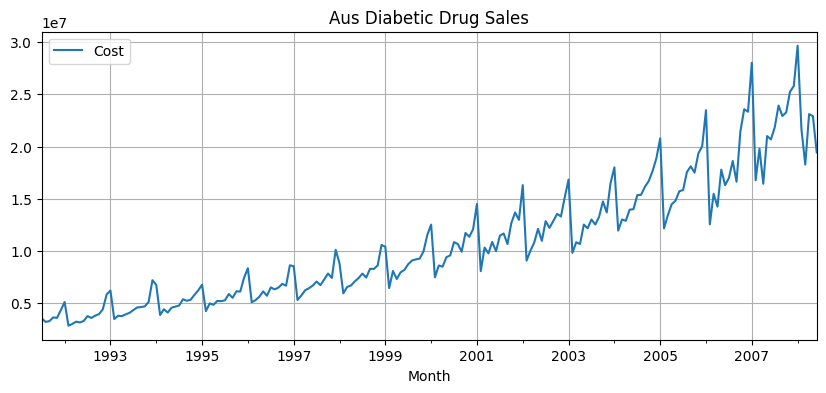

In [37]:
dfbs = dfbs.loc[dfbs['ATC2'] == 'A10', ['Month', 'Cost', 'Type', 'Concession']]

dfbs[['Month', 'Cost']].groupby('Month').sum().plot(grid=True, figsize=(10,4), title='Aus Diabetic Drug Sales');

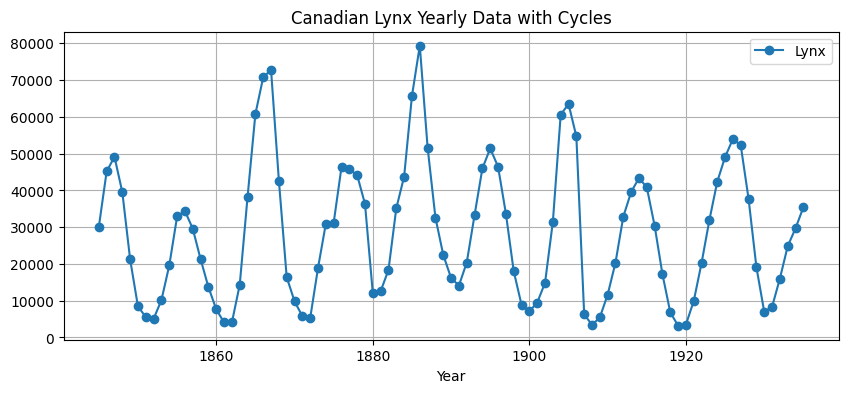

In [15]:
df_l.plot(
    x="Year",
    y="Lynx",
    grid=True,
    figsize=(10,4),
    marker="o",
    title='Canadian Lynx Yearly Data with Cycles'
);

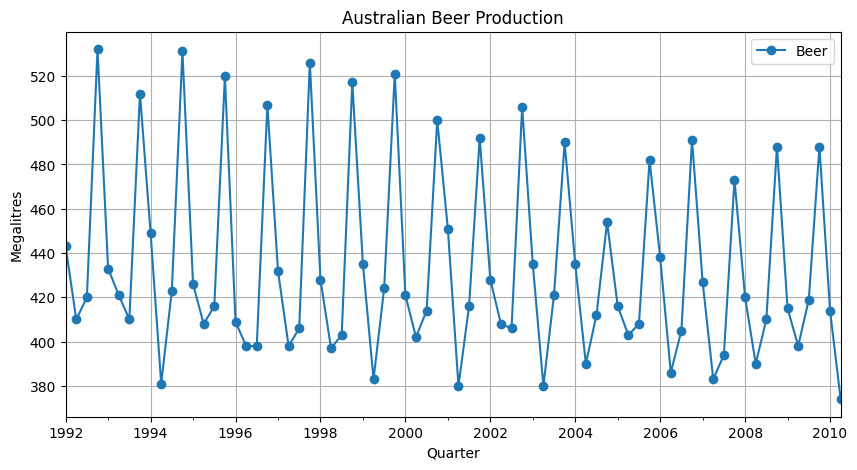

In [45]:
beer = beer.loc[beer.Quarter.dt.year >= 1992, ['Quarter', 'Beer']].reset_index(drop=True)

ax = beer.plot(
    kind='line',
    x='Quarter',
    y='Beer',
    figsize=(10,5),
    grid='on',
    title='Australian Beer Production',
    ylabel='Megalitres',
    marker='o'
);

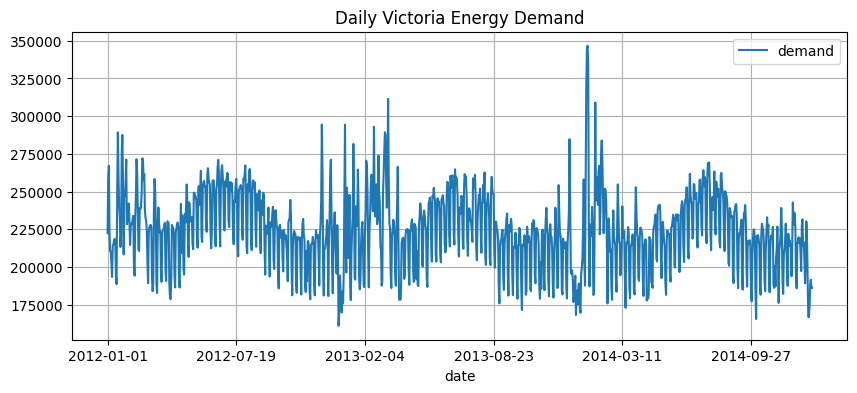

In [51]:
vic_elec[['demand', 'date']].groupby('date').sum().plot(figsize=(10,4), title='Daily Victoria Energy Demand', grid=2);

#### 2.0. Seasonal Plots

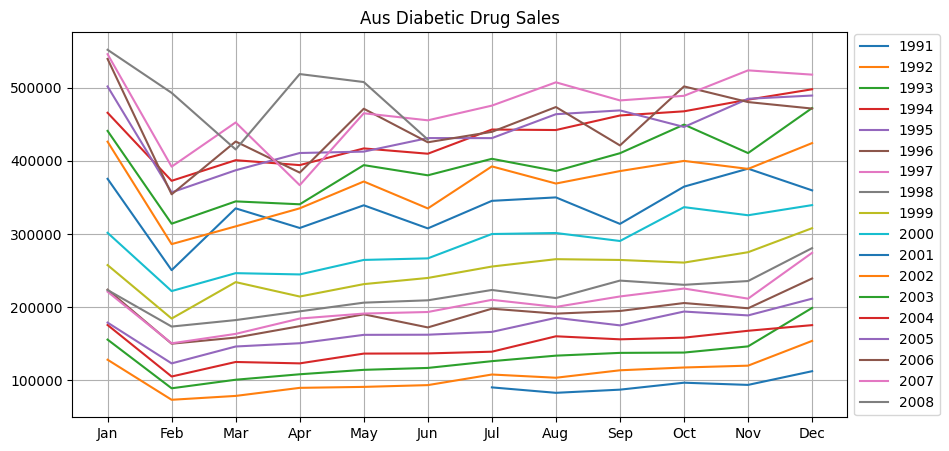

In [58]:
dfbs['month_index'] = dfbs['Month'].dt.month
dfbs['year'] = dfbs['Month'].dt.year

dfbs_plot = dfbs[['month_index', 'year', 'Cost']].groupby(['year', 'month_index']).sum('Cost').reset_index()
dfbs_plot = dfbs_plot.sort_values(by=['year', 'month_index'])

dfbs_plot['Cost'] = dfbs_plot['Cost'] / 1_000

fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(
    ticks=range(1, len(dfbs_plot.month_index.unique()) + 1), 
    labels=[month_abbr[k] for k in set(dfbs_plot.month_index.unique())]
)

for variable in dfbs_plot['year'].unique():
    aux = dfbs_plot[dfbs_plot['year'] == variable]
    ax.plot(aux['month_index'], aux['Cost'], label=variable)

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_title('Aus Diabetic Drug Sales')
ax.grid(2)

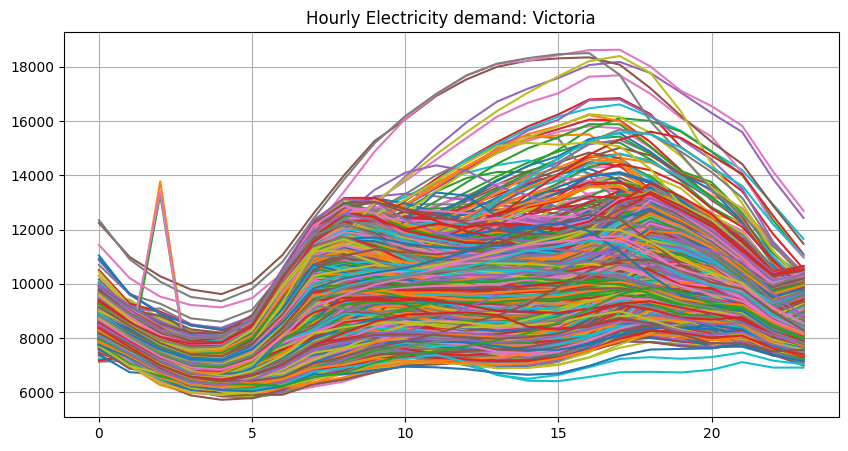

In [55]:
vic_elec['time'] = pd.to_datetime(vic_elec['time'])
vic_elec['hour'] = vic_elec['time'].dt.hour
vic_elec['date_index'] = vic_elec['time'].dt.normalize()

fig, ax = plt.subplots(figsize=(10, 5))

for variable in vic_elec['date_index'].unique():
    aux = vic_elec[vic_elec['date_index'] == variable]
    aux = aux[['hour', 'demand']].groupby('hour').sum().reset_index()
    ax.plot(aux['hour'], aux['demand'])

ax.set_title("Hourly Electricity demand: Victoria")

ax.grid(2)

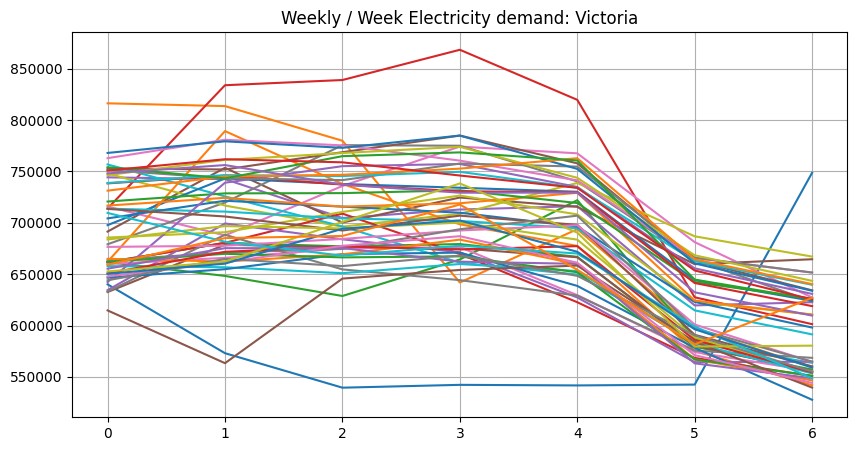

In [56]:
vic_elec["week"] = vic_elec["date_index"].dt.isocalendar()["week"]
vic_elec['weekday'] = vic_elec["date_index"].dt.weekday

fig, ax = plt.subplots(figsize=(10, 5))

for variable in vic_elec['week'].unique():
    aux = vic_elec[vic_elec['week'] == variable]
    aux = aux[['weekday', 'demand']].groupby('weekday').sum().reset_index()
    ax.plot(aux['weekday'], aux['demand'])

ax.set_title("Weekly / Week Electricity demand: Victoria")
ax.grid(2)

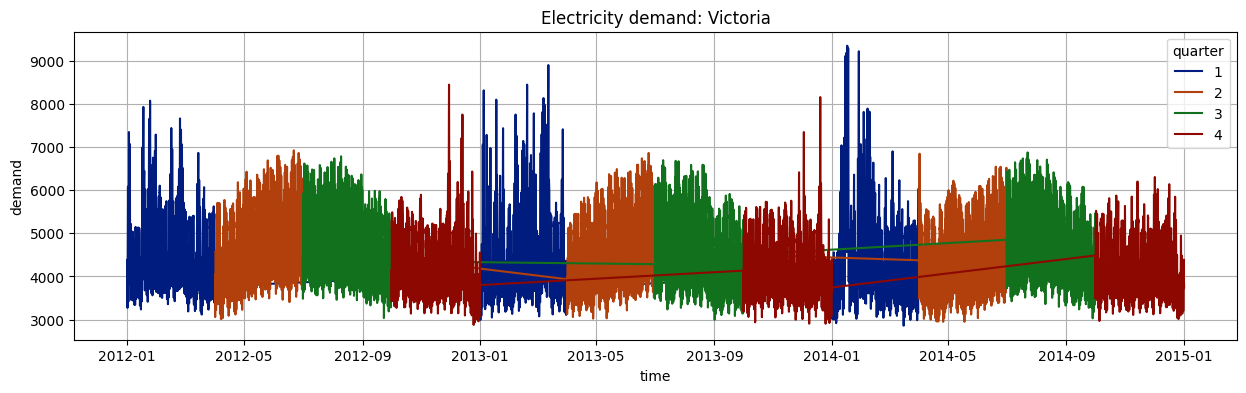

In [68]:
fig, ax = plt.subplots(figsize=(15,4))
ax.grid(2)
ax.set_title("Electricity demand: Victoria")
sns.lineplot(data=vic_elec, x="time", y="demand", hue="quarter", ax=ax, palette="dark");

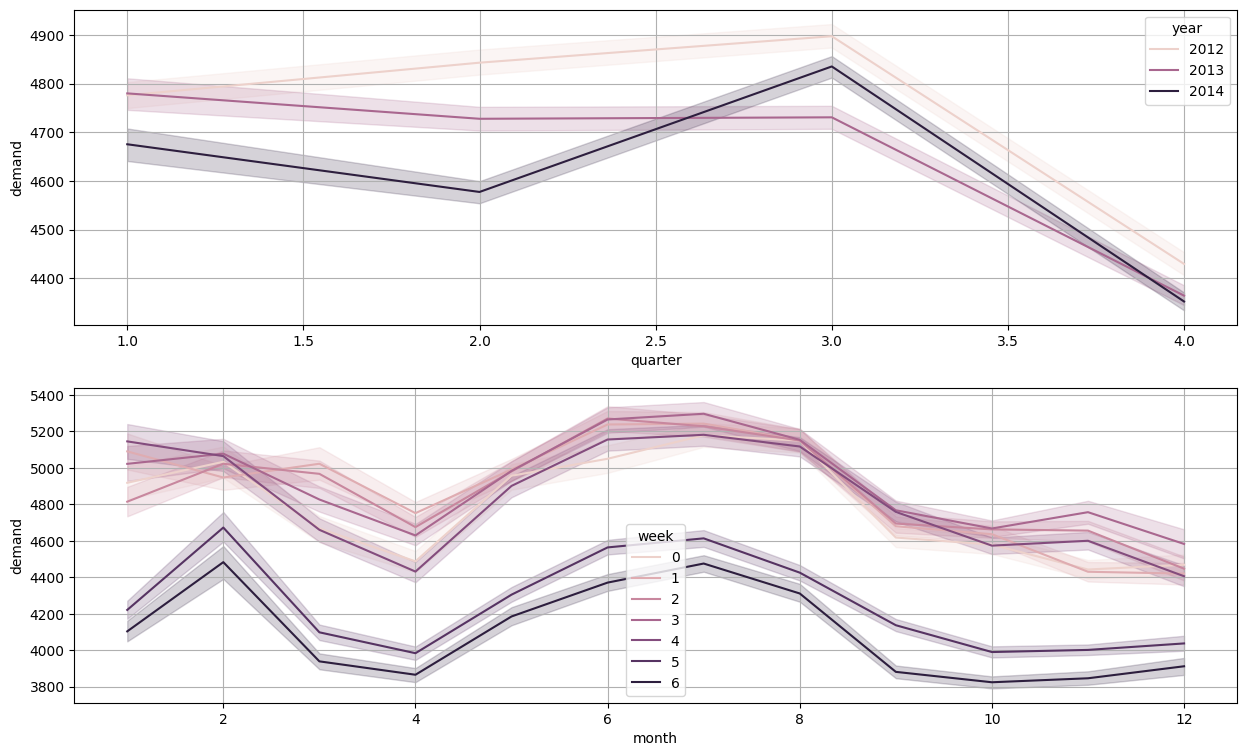

In [55]:
vic_elec['week'] = vic_elec.time.dt.day_of_week
vic_elec['month'] = vic_elec.time.dt.month
vic_elec['year'] = vic_elec.time.dt.year
vic_elec['quarter'] = vic_elec.time.dt.quarter

fig, ax = plt.subplots(2, 1, figsize=(15,9))
sns.lineplot(vic_elec, x='quarter', y='demand', hue='year', ax=ax[0])
sns.lineplot(vic_elec, x='month', y='demand', hue='week', ax=ax[1]);
for axi in ax: axi.grid(2)

#### 3.0. Subseries & Month Plots

In [4]:
beer_plot = beer.copy()
beer_plot['Year'] = beer.Quarter.dt.year
beer_plot['Q'] = beer_plot.Quarter.dt.quarter

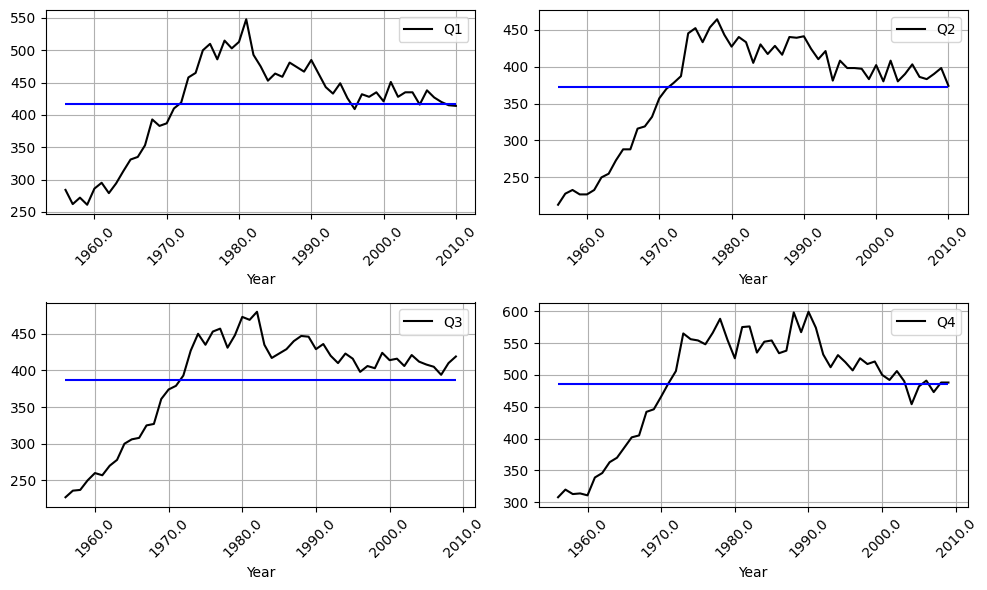

In [60]:
fig, ax = plt.subplots(2, 2, figsize=(10,6))
ax = ax.flatten()
for i, q in enumerate(beer_plot['Q'].unique()):
    axis = beer_plot.loc[beer_plot['Q'] == q, ['Beer', 'Q', 'Year']].plot(
        kind='line', x='Year', y='Beer', 
        label= f'Q{q}', ax=ax[i], color='k', grid='on'
    )
    axis = axis.get_children()[0]
    ax[i].hlines(
        y=np.mean(axis.get_ydata()), 
        xmin=axis.get_xdata()[0], 
        xmax=axis.get_xdata()[-1],
        color='b'
    )
    ax[i].set_xticklabels(ax[i].get_xticks(), rotation = 45)
plt.tight_layout()

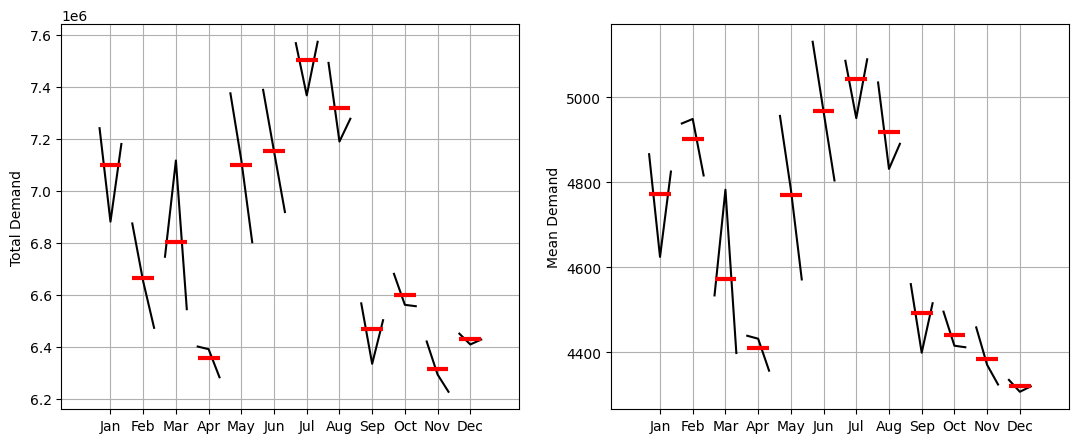

In [64]:
aux = vic_elec.set_index('time')

fig, ax = plt.subplots(1, 2, figsize=(13,5))
month_plot(aux['demand'].resample('M').sum(), ylabel='Total Demand', ax=ax[0]);
month_plot(aux['demand'].resample('M').mean(), ylabel='Mean Demand', ax=ax[1]);
for axi in ax: axi.grid(2)

#### 4.0. Scatterplots

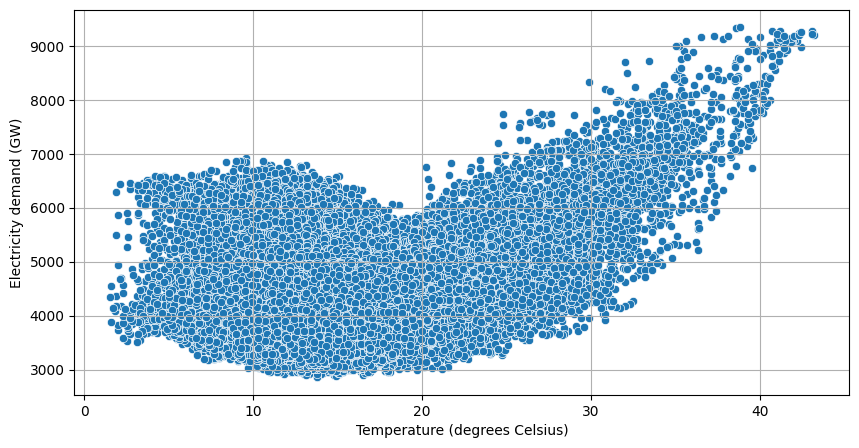

In [65]:
fig, ax = plt.subplots(figsize=(10,5))
sns.scatterplot(vic_elec, x='temperature', y='demand', ax=ax);
ax.set_xlabel("Temperature (degrees Celsius)");
ax.set_ylabel("Electricity demand (GW)");
ax.grid(3);

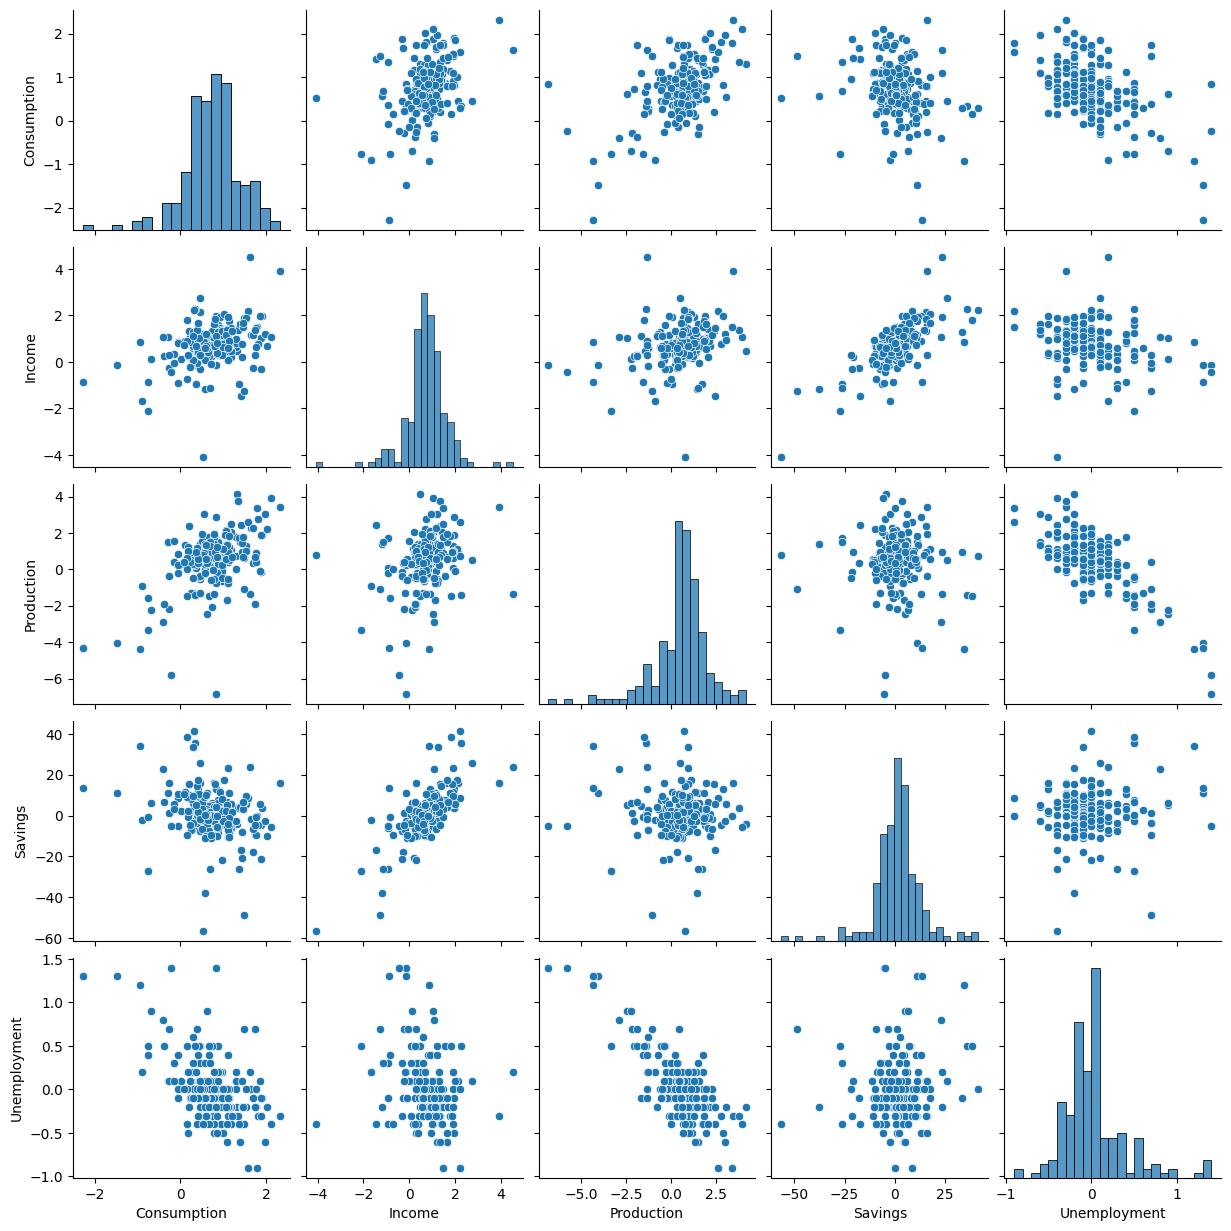

In [7]:
sns.pairplot(df[["Consumption", "Income", "Production", "Savings", "Unemployment"]]);

#### 5.0. Lag Plots

O Lag plot está vinculado com a variável de time series no tempo t ($y_y$) e seus outros valores em k passos, podemos reescrever isso assim: $y_{t-k}$.
Em outras palavras, um lag plot verifica se um conjunto dos dados ou série temporal é aleatório ou não. Dados aleatórios não devem apresentar nenhuma estrutura identificável no gráfico.


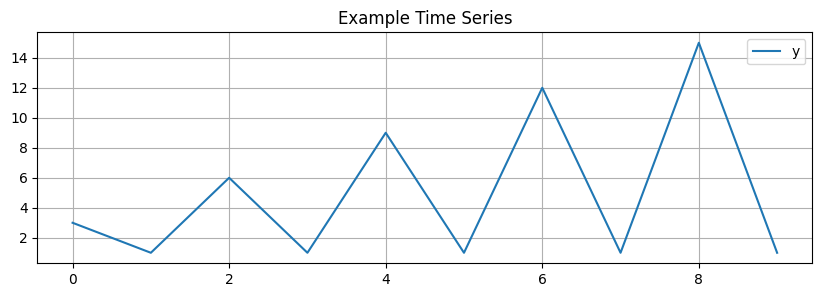

In [30]:
dff = pd.DataFrame(
    [3, 1, 6, 1, 9, 1, 12, 1, 15, 1]
).rename(columns={0:"y"})

dff.plot(figsize=(10, 3), grid=2, title="Example Time Series");

Eu espero ver uma boa correlação nessa serie das variáveis "lagadas" ou $y_{t-k}$. 

In [31]:
for k in range(1, 5):
    dff[f"lag_{k}"] = dff["y"].shift(k)

dff

,y,lag_1,lag_2,lag_3,lag_4
0,3,NaN,NaN,NaN,NaN
1,1,3.0,NaN,NaN,NaN
2,6,1.0,3.0,NaN,NaN
3,1,6.0,1.0,3.0,NaN
4,9,1.0,6.0,1.0,3.0
5,1,9.0,1.0,6.0,1.0
6,12,1.0,9.0,1.0,6.0
7,1,12.0,1.0,9.0,1.0
8,15,1.0,12.0,1.0,9.0
9,1,15.0,1.0,12.0,1.0


O Gráfico abaixo mostra uma relação não aleatória no Lag 2 e 4.

Os lag plots podem fornecer respostas às seguintes perguntas:
1. Os dados são aleatórios?
2. Existe correlação nos dados?
3. Qual é um modelo adequado para os dados?
4. Existem valores discrepantes nos dados?

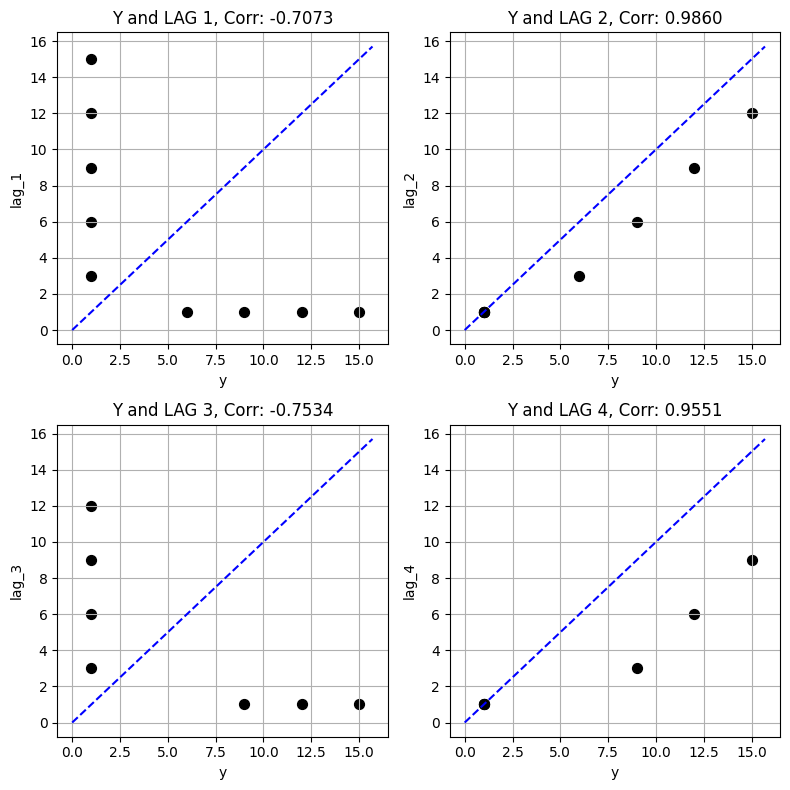

In [76]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()

for axi, k in zip(ax, range(1, 5)):
    corr = dff[["y", f"lag_{k}"]].corr().iloc[:, -1]["y"]
    dff.plot(kind="scatter", x="y", y=f"lag_{k}", marker="o", color="k", s=[50], ax=axi, title=f"Y and LAG {k}, Corr: {corr:.4f}")
    
    l, p = axi.get_xlim()
    axi.plot([0, p], [0, p], "b--")
    axi.grid(2)

plt.tight_layout()

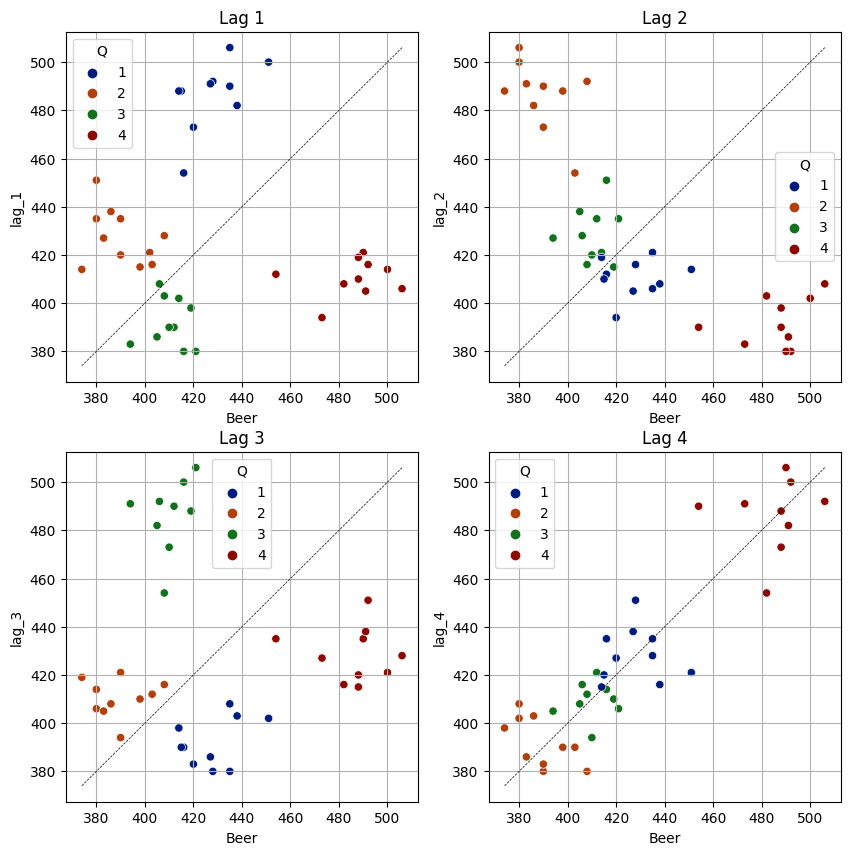

In [66]:
beer_plot = beer[beer.Quarter.dt.year >= 2000]
beer_plot['Q'] = beer_plot['Quarter'].dt.quarter

# Create Lag Columns
for k in range(1, 5):
    beer_plot[f'lag_{k}'] = beer_plot['Beer'].shift(k)

# Plot data
fig, ax = plt.subplots(2, 2, figsize=(10,10))
ax = ax.flatten()
for i, k in enumerate(beer_plot.columns[beer_plot.columns.str.contains('lag')]):
    sns.scatterplot(beer_plot, x='Beer', y=k, hue='Q', palette='dark', ax=ax[i])
    ax[i].set_title(k.replace('_', ' ').capitalize())
    ax[i].plot(
        [beer_plot['Beer'].min(), beer_plot['Beer'].max()], 
        [beer_plot['Beer'].min(), beer_plot['Beer'].max()], 
        'k--', lw=0.5,
    )
    ax[i].grid('on')

#### 6.0. Autocorrelation Plots

Após o Lag Plot, na maioria das vezes utilizamos o gráfico de Autocorrelação.
Podemos ter uma boa ideia utilizando a correlação de Pearson apenas para ter um indicativo de quais bolinhas não estão para cima e quais vão ser para baixo no gráfico de Autocorrelação.


Aplicando a os nossos dados de exemplos, temos o seguinte gráfico:


In [100]:
dff.corr()

,y,lag_1,lag_2,lag_3,lag_4
y,1.000000,-0.707252,0.986034,-0.753352,0.955098
lag_1,-0.707252,1.000000,-0.722701,0.985087,-0.784036
lag_2,0.986034,-0.722701,1.000000,-0.727914,0.980609
lag_3,-0.753352,0.985087,-0.727914,1.000000,-0.754314
lag_4,0.955098,-0.784036,0.980609,-0.754314,1.000000


O gráfico de Autocorrelação é outra ferramenta para verificar a aleatoriedade em um conjunto de dados, calcula-se autocorrelações em tempos variados partindo de $y_t$ (por isso sempre pulamos o lag = 0 no statsmodels, pois vai ser a autocorrelação de $y_t$ com $y_t$).


Assim como a correlação mede a correlação de uma relação linear entre duas variáveis, a autocorrelação mede a relação linear entre valores "lagados" ($y_{t-k}$) de uma série temporal.


Se o dado for aleatório, as correlações vão ser próximas de 0, caso contrário irão apresentar algum valor ao longo do gráfico. Em especial, o gráfico de correlação ajuda a selecionar modelos Autoregressivos (Box-Jenkins).


No entanto, dados que não mostram autocorrelação significativa ainda podem exibir não aleatoriedade de outras maneiras.


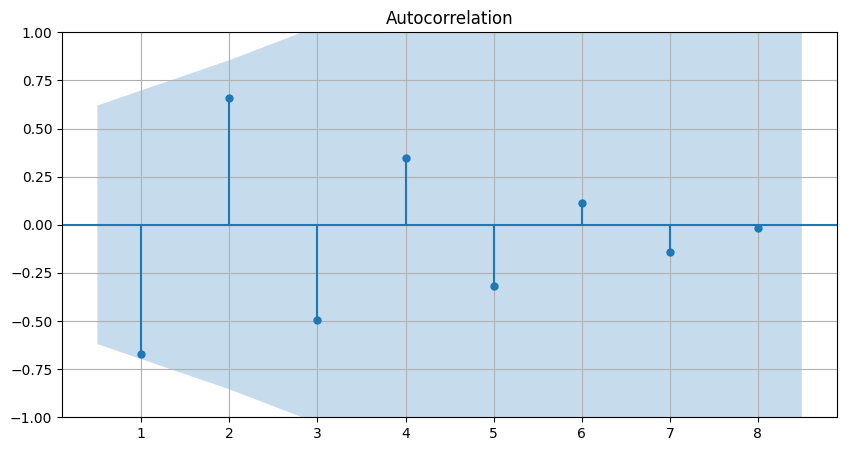

In [82]:
fig, ax = plt.subplots(figsize=(10,5))
acf = plot_acf(dff['y'], lags=range(1, 9), ax=ax);
ax.grid(2)

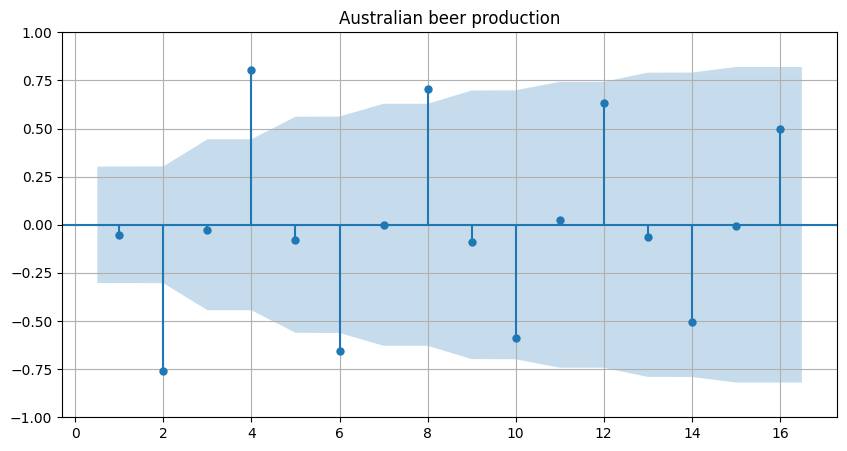

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
plot_acf(beer_plot['Beer'], lags=range(1, 17), ax=ax);
ax.set_title("Australian beer production");
ax.grid(2)

Sobre acf & pacf, no livro não é abordado a pacf, mas nós podemos utilizar ele para indentificar modelos arma.

Mais detales aqui: https://youtu.be/KAOkH8P8anE

#### 7.0. White Noise

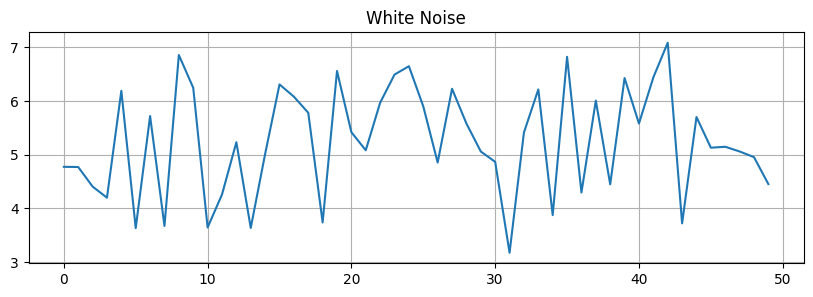

In [101]:
np.random.seed(90)
y = np.random.normal(5, size=50)

fig, ax = plt.subplots(figsize=(10,3))
ax.plot(y);
ax.set_title('White Noise');
ax.grid(2);

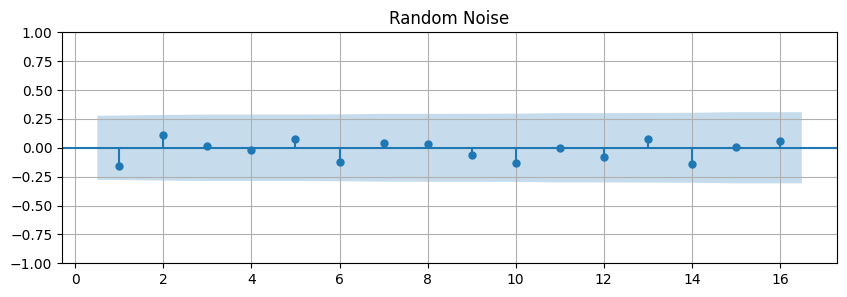

In [102]:
fig, ax = plt.subplots(figsize=(10,3))
plot_acf(y, lags=range(1, 17), ax=ax);
ax.set_title("Random Noise");
ax.grid(2)